# Importing libraries

In [1]:
import os
import time

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Set the device 
device =  ['cuda' if torch.cuda.is_available() else 'cpu']

# Dowload the Dataset and Prepare the Input as List

Data Link : https://ai.stanford.edu/~amaas/data/sentiment/

Prepare the data in following format 

text_data = [x1 ,x2 ,x3 ,x4 ...xn] 

label = [y1, y2, y3, y4, .....yn]

* Remove the punctuations from the text data


In [3]:
root_path = '/mnt/f/Rohan/Ubuntu_2204/projects/mastering_pytorch/sentiment_analysis'
data_path = '/data/aclImdb_v1/aclImdb/'
def extract_data(path):
    review_list = []
    label_list = []
    for label in ['pos','neg']:
        for filename in os.listdir(path+'/train/'+label+'/'):
            if 'txt' not in filename:
                continue
            with open(path+'/train/'+label+'/'+filename) as f:
                review_list.append(f.read())
                label_list.append(label)
    return review_list,label_list

In [4]:
train_list,train_label = extract_data(root_path+data_path)

In [5]:
print(f"The total number of Reviews are: {len(train_list)}")

The total number of Reviews are: 25000


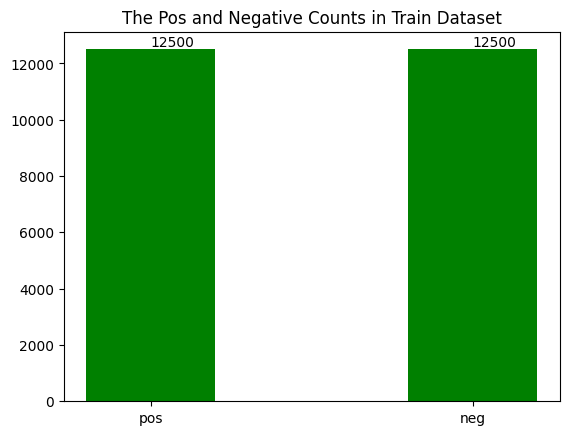

In [6]:
# Plotting the total number of Postive and Negative Reviews
train_values = list(Counter(train_label).values())
train_keys = list(Counter(train_label).keys())

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]+100,y[i])
    
plt.bar(train_keys, train_values, width = 0.4,color='g')
plt.title('The Pos and Negative Counts in Train Dataset')
addlabels(train_keys, train_values)
plt.show()

## PreProcess the Reviews

In [7]:
#Convert all the enteries to lower case
train_list = [review.lower() for review in train_list]

In [8]:
train_list_updated = [''.join([letter for letter in review
                        if letter not in punctuation])for review in train_list]

In [9]:
train_list_updated

['bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt',
 'homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter most

In [10]:
reviews_accl = ' '.join(train_list_updated)
review_words = reviews_accl.split()
count_words = Counter(review_words)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

In [11]:
sorted_review_words

[('the', 334691),
 ('and', 162228),
 ('a', 161940),
 ('of', 145326),
 ('to', 135042),
 ('is', 106855),
 ('in', 93028),
 ('it', 77099),
 ('i', 75719),
 ('this', 75190),
 ('that', 69352),
 ('br', 57143),
 ('was', 48008),
 ('as', 46662),
 ('for', 43964),
 ('with', 43871),
 ('movie', 41807),
 ('but', 41739),
 ('film', 37455),
 ('on', 33505),
 ('not', 30190),
 ('you', 29497),
 ('are', 29324),
 ('his', 29249),
 ('have', 27667),
 ('he', 26647),
 ('be', 26631),
 ('one', 25508),
 ('its', 25054),
 ('at', 23359),
 ('all', 23156),
 ('by', 22365),
 ('an', 21487),
 ('they', 20958),
 ('from', 20392),
 ('who', 20369),
 ('so', 19890),
 ('like', 19641),
 ('her', 18138),
 ('just', 17629),
 ('or', 17603),
 ('about', 17240),
 ('has', 16710),
 ('if', 16606),
 ('out', 16331),
 ('some', 15678),
 ('there', 15362),
 ('what', 15207),
 ('good', 14555),
 ('when', 14087),
 ('more', 14074),
 ('very', 13993),
 ('even', 12503),
 ('she', 12475),
 ('my', 12443),
 ('no', 12293),
 ('up', 12203),
 ('would', 12135),
 ('whic

In [12]:
#Create Vocabulary of the words
vocab_to_token = {word: idx+1 for idx,(word,count) in enumerate(sorted_review_words)}
vocab_to_token['unkwn'] = len(vocab_to_token)+1

In [13]:
#Convert the reviews to token state
tokenized_reviews = []
for reviews in train_list_updated:
    word2token=[]
    for word in reviews.split():
        if word not in vocab_to_token: 
            word = 'unkwn' 
        word2token.append(vocab_to_token[word])
    tokenized_reviews.append(word2token)

print(f"{train_list_updated[0]}")
print("**************************************")
print(print(f"{tokenized_reviews[0]}"))

bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt
**************************************
[22572, 321, 6, 3, 1077, 219, 8, 2082, 30, 1, 166, 61, 14, 46, 80, 5581, 42, 399, 118, 135, 14, 4883, 55, 4980, 147, 7, 1, 4941, 6023, 479, 69, 5, 255, 11, 22572, 17217, 1970, 6, 72, 2356, 5, 638, 7

In [14]:
#Encode the Labels 
encoded_labels = [1 if label == 'pos' else 0 for label in train_label]

In [15]:
# Pad the sequence to a fixed sequence length
def pad_sequence(tokenized_reviews, sequence_length):
    padded_reviews = np.zeros((len(tokenized_reviews), sequence_length),dtype = int)
    review_len_list= []
    for idx, review in enumerate(tokenized_reviews):
        review_len = len(review)
        review_len_list.append(review_len)
        if review_len <= sequence_length:
            zeroes = list(np.zeros(
                sequence_length-review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]
        padded_reviews[idx,:] = np.array(new_sequence)
    return padded_reviews, review_len_list

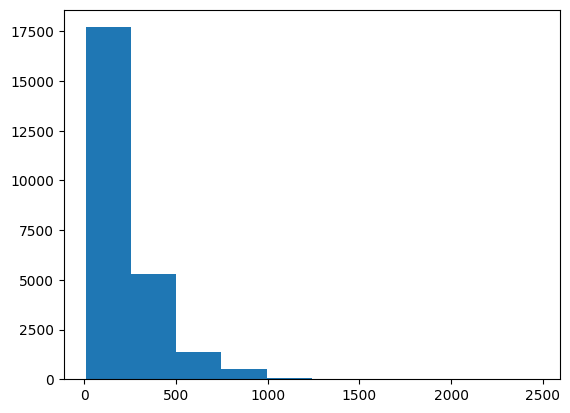

In [16]:
sequence_length = 512
padded_reviews, review_len = pad_sequence(tokenized_reviews, sequence_length)
plt.hist(review_len);

## Create Train and Test Split

In [17]:
train_val_split = 0.8

trainX = padded_reviews[:int(train_val_split*len(padded_reviews))]
trainy = encoded_labels[:int(train_val_split*len(padded_reviews))]
valX = padded_reviews[int(train_val_split*len(padded_reviews)):]
valy = encoded_labels[int(train_val_split*len(padded_reviews)):]

In [18]:
train_dataset = TensorDataset(torch.from_numpy(np.array(trainX)),torch.from_numpy(np.array(trainy)))
val_dataset = TensorDataset(torch.from_numpy(np.array(valX)),torch.from_numpy(np.array(valy)))

batch_size = 32
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [19]:
iter_train_load = iter(train_loader)
X1, y1 = next(iter_train_load)
# batch_size, seq_length
print('Example Input size: ', X1.size()) 
print('Example Input:\n', X1)
print()
# batch_size
print('Example Output size: ', y1.size()) 
print('Example Output:\n', y1)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[    0,     0,     0,  ...,   335,   164,  1597],
        [    0,     0,     0,  ...,   197,   293,  1217],
        [    0,     0,     0,  ...,     8,    49,  6871],
        ...,
        [    0,     0,     0,  ...,   367,    10,    17],
        [    0,     0,     0,  ...,     5,   789, 15736],
        [    0,     0,     0,  ..., 10473,    14,   726]])

Example Output size:  torch.Size([32])
Example Output:
 tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0])


# Creating the Model and Training

In [20]:
 class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, 
                 hidden_dimension, output_dimension):
        super().__init__()
        #Deep Recurrent Model Architectures
        self.embedding_layer = nn.Embedding(input_dimension,embedding_dimension)
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension,num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension,output_dimension)
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)     
        #embedding shape = [sequence_length, batch_size,embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size,hidden_dimension]
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))
        return final_output

In [21]:
input_dimension = len(vocab_to_token) + 1
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension,hidden_dimension, output_dimension)
optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()
rnn_model = rnn_model.to(device[0])
loss_func = loss_func.to(device[0])

In [22]:
print(rnn_model)

RNN(
  (embedding_layer): Embedding(121366, 100)
  (rnn_layer): RNN(100, 32)
  (fc_layer): Linear(in_features=32, out_features=1, bias=True)
)


In [23]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set 
    of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = \
        torch.round(torch.sigmoid(predictions))
    # convert into float for division
    success = (rounded_predictions == ground_truth).float()
    accuracy = success.sum() / len(success)
    return accuracy

In [24]:
def train(model,dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    for sequence,sentiment in dataloader:
        optim.zero_grad()
        sequence = sequence.to(device[0])
        sentiment = sentiment.to(device[0])
        preds = model(sequence.T).squeeze()
        loss_val = loss_func(preds,sentiment.float())
        acc_val = accuracy_metric(preds,sentiment)
        loss_val.backward()
        optim.step()
        loss = loss  + loss_val.item()
        accuracy = accuracy + acc_val.item()
    return loss/len(dataloader), accuracy/len(dataloader)
        

In [25]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            sequence = sequence.to(device[0])
            sentiment = sentiment.to(device[0])
            preds = model(sequence.T).squeeze()
            loss_curr = loss_func(preds, sentiment.float())
            accuracy_curr = accuracy_metric(preds, sentiment)
            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
    return loss/len(dataloader), accuracy/len(dataloader)

In [26]:
num_epochs = 100
best_validation_loss = float('inf')
for ep in range(num_epochs):
    time_start = time.time()
    training_loss, train_accuracy = train(rnn_model, train_loader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, val_loader, loss_func)
    time_end = time.time()
    time_delta = time_end - time_start
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')

epoch number: 1 | time elapsed: 8.712198257446289s
training loss: 0.642 | training accuracy: 63.27%
validation loss: 0.859 |  validation accuracy: 38.48%
epoch number: 2 | time elapsed: 3.795440435409546s
training loss: 0.551 | training accuracy: 72.50%
validation loss: 0.859 |  validation accuracy: 50.32%
epoch number: 3 | time elapsed: 3.686974287033081s
training loss: 0.485 | training accuracy: 77.14%
validation loss: 0.728 |  validation accuracy: 64.97%
epoch number: 4 | time elapsed: 3.7643585205078125s
training loss: 0.436 | training accuracy: 80.36%
validation loss: 0.771 |  validation accuracy: 64.13%
epoch number: 5 | time elapsed: 3.706575632095337s
training loss: 0.389 | training accuracy: 83.17%
validation loss: 0.828 |  validation accuracy: 61.39%
epoch number: 6 | time elapsed: 4.002741813659668s
training loss: 0.331 | training accuracy: 86.70%
validation loss: 0.889 |  validation accuracy: 63.71%
epoch number: 7 | time elapsed: 4.016672849655151s
training loss: 0.275 | t

In [27]:
def sentiment_inference(model, sentence, sequence_length = sequence_length):
    model.eval()
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence
                       if c not in punctuation])
    tokenized = []
    for token in sentence.split():
        if token not in vocab_to_token:
            token = 'unkwn'
        tokenized.append(vocab_to_token[token])

    if len(tokenized) <= sequence_length:
            zeroes = list(np.zeros(sequence_length-len(tokenized)))
            new_sequence = zeroes+tokenized
    elif len(tokenized) > sequence_length:
            new_sequence = tokenized[0:sequence_length]
    
    # model inference
    model_input = torch.from_numpy(np.array(tokenized)).to(device[0])
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))
    return pred.item()

In [28]:
print(sentiment_inference(rnn_model,"This film is horrible"))

2.8866495540569304e-06


In [29]:
print(sentiment_inference(rnn_model,"This film will be housefull for weeks"))
print(sentiment_inference(rnn_model," I just really loved the movie"))

0.9998353719711304
0.07985328137874603


# RNN Model With DropOut Layer

In [39]:
 class RNN_DP(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, 
                 hidden_dimension, output_dimension):
        super().__init__()
        #Deep Recurrent Model Architectures
        self.embedding_layer = nn.Embedding(input_dimension,embedding_dimension)
        self.bn = nn.BatchNorm1d(embedding_dimension)
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension,num_layers=3)
        self.dp = nn.Dropout(p = 0.2)
        self.fc_layer = nn.Linear(hidden_dimension,output_dimension)
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)
        #print(embedding.size())
        embedding = self.bn(embedding.permute(1,2,0))
        #embedding shape = [sequence_length, batch_size,embedding_dimension]
        #print(embedding.size())
        output, hidden_state = self.rnn_layer(embedding.permute(2,0,1))
        #output shape = [sequence_length, batch_size, hidden_dimension]
        #hidden_state shape = [1, batch_size,hidden_dimension]
        hidden_state = self.dp(hidden_state[-1,:,:].squeeze(0))
        final_output = self.fc_layer(hidden_state)
        return final_output

In [40]:
input_dimension = len(vocab_to_token) + 1
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model_dp = RNN_DP(input_dimension, embedding_dimension,hidden_dimension, output_dimension)
rnn_model_dp = rnn_model_dp.to(device[0])
print(rnn_model_dp)

RNN_DP(
  (embedding_layer): Embedding(121366, 100)
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn_layer): RNN(100, 32, num_layers=3)
  (dp): Dropout(p=0.2, inplace=False)
  (fc_layer): Linear(in_features=32, out_features=1, bias=True)
)


In [41]:
num_epochs = 100
best_validation_loss = float('inf')
for ep in range(num_epochs):
    time_start = time.time()
    training_loss, train_accuracy = train(rnn_model_dp, train_loader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model_dp, val_loader, loss_func)
    time_end = time.time()
    time_delta = time_end - time_start
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model_dp.state_dict(), 'rnn_model_dp.pt')
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')

epoch number: 1 | time elapsed: 3.0212504863739014s
training loss: 0.685 | training accuracy: 55.78%
validation loss: 0.743 |  validation accuracy: 19.11%
epoch number: 2 | time elapsed: 3.0171523094177246s
training loss: 0.685 | training accuracy: 56.02%
validation loss: 0.743 |  validation accuracy: 19.01%
epoch number: 3 | time elapsed: 3.062732458114624s
training loss: 0.685 | training accuracy: 55.94%
validation loss: 0.742 |  validation accuracy: 19.13%
epoch number: 4 | time elapsed: 2.985016345977783s
training loss: 0.685 | training accuracy: 55.85%
validation loss: 0.742 |  validation accuracy: 19.15%
epoch number: 5 | time elapsed: 2.979128360748291s
training loss: 0.685 | training accuracy: 55.80%
validation loss: 0.743 |  validation accuracy: 19.01%
epoch number: 6 | time elapsed: 3.0415542125701904s
training loss: 0.686 | training accuracy: 55.88%
validation loss: 0.743 |  validation accuracy: 19.19%
epoch number: 7 | time elapsed: 3.063065767288208s
training loss: 0.685 |

KeyboardInterrupt: 

# LSTM Layer

In [42]:
class LSTM(nn.Module):

    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension, dropout):
        
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension,embedding_dimension)
        self.lstm_layer = nn.LSTM(embedding_dimension, hidden_dimension, num_layers=1,  bidirectional=True, dropout=dropout)
        self.fc_layer = nn.Linear(hidden_dimension*2,output_dimension)

    def forward(self,sequence):
        embedding = self.embedding_layer(sequence)
        packed_output, (hidden_state, cell_state) = self.lstm_layer(embedding)
        hidden_output = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1) 
        return self.fc_layer(hidden_output)

In [44]:
input_dimension = len(vocab_to_token) + 1
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

lstm_model = LSTM(input_dimension, embedding_dimension,hidden_dimension, output_dimension, dropout=0.2)
lstm_model = lstm_model.to(device[0])
print(lstm_model)

LSTM(
  (embedding_layer): Embedding(121366, 100)
  (lstm_layer): LSTM(100, 32, dropout=0.2, bidirectional=True)
  (fc_layer): Linear(in_features=64, out_features=1, bias=True)
)


/mnt/f/Rohan/Ubuntu_2204/virtual_env/venv_master_pytorch/lib/python3.12/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [45]:
num_epochs = 100
best_validation_loss = float('inf')
for ep in range(num_epochs):
    time_start = time.time()
    training_loss, train_accuracy = train(lstm_model, train_loader, optim, loss_func)
    validation_loss, validation_accuracy = validate(lstm_model, val_loader, loss_func)
    time_end = time.time()
    time_delta = time_end - time_start
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model_dp.state_dict(), 'rnn_model_dp.pt')
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')

epoch number: 1 | time elapsed: 3.253176212310791s
training loss: 0.685 | training accuracy: 59.03%
validation loss: 0.732 |  validation accuracy: 16.26%
epoch number: 2 | time elapsed: 2.6814191341400146s
training loss: 0.685 | training accuracy: 59.03%
validation loss: 0.732 |  validation accuracy: 16.26%
epoch number: 3 | time elapsed: 2.7116916179656982s
training loss: 0.685 | training accuracy: 59.03%
validation loss: 0.732 |  validation accuracy: 16.20%
epoch number: 4 | time elapsed: 2.784104347229004s
training loss: 0.685 | training accuracy: 59.03%
validation loss: 0.732 |  validation accuracy: 16.32%
epoch number: 5 | time elapsed: 2.732991933822632s
training loss: 0.685 | training accuracy: 59.03%
validation loss: 0.732 |  validation accuracy: 16.32%
epoch number: 6 | time elapsed: 2.6885459423065186s
training loss: 0.685 | training accuracy: 59.03%
validation loss: 0.732 |  validation accuracy: 16.14%
epoch number: 7 | time elapsed: 2.711056709289551s
training loss: 0.685 |